In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Don't forget to use `ml_env` environment
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SequentialFeatureSelector


In [2]:
pd.set_option('display.max_columns', 50)

def clear_cols(s):
    return s.strip().replace(" ","_")

In [3]:
inpatient_path   = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Inpatientdata-1542865627584.csv'
outpatient_path  = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Outpatientdata-1542865627584.csv'
train_path       = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train-1542865627584.csv'
beneficiary_path = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Beneficiarydata-1542865627584.csv'

# read inpatient outpatient and train files data
inpatient  = pd.read_csv(inpatient_path).rename(columns=clear_cols)
outpatient = pd.read_csv(outpatient_path).rename(columns=clear_cols)
train      = pd.read_csv(train_path).rename(columns=clear_cols)
bene       = pd.read_csv(beneficiary_path).rename(columns=clear_cols)

In [4]:
train.sample()

,Provider,PotentialFraud
3125,PRV54909,No


In [5]:
inpatient.sample()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
27302,BENE111073,CLM80248,2009-12-20,2009-12-30,PRV52027,51000,PHY387861,PHY327938,NaN,2009-12-20,5849,1068.0,2009-12-30,867,0389,43820,34830,261,5070,V440,51881,V667,49121,NaN,9672.0,NaN,NaN,NaN,NaN,NaN


In [6]:
outpatient.sample()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
514069,BENE158145,CLM111573,2008-12-26,2009-01-15,PRV54895,1600,PHY347629,PHY337968,NaN,V562,27540,2809,28521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


In [7]:
# convert dates to datetime format in outpatient
outpatient['ClaimStartDt'] = pd.to_datetime(outpatient['ClaimStartDt'])
outpatient['ClaimEndDt'] = pd.to_datetime(outpatient['ClaimEndDt'])
outpatient['ClaimDuration'] = (outpatient['ClaimEndDt'] - outpatient['ClaimStartDt']).dt.days.astype(int)
outpatient

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode,ClaimDuration
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,V5866,V1272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409,0
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380,0
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,30000,72887,4280,7197,V4577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,71947,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517732,BENE159198,CLM510792,2009-08-06,2009-08-06,PRV53699,800,PHY364188,PHY364188,PHY385752,2163,V4575,53190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
517733,BENE159198,CLM551294,2009-08-29,2009-08-29,PRV53702,400,PHY423019,PHY332284,NaN,07041,5781,25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
517734,BENE159198,CLM596444,2009-09-24,2009-09-24,PRV53676,60,PHY361063,NaN,NaN,V570,78079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
517735,BENE159198,CLM636992,2009-10-18,2009-10-18,PRV53689,70,PHY403198,NaN,PHY419379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0


In [8]:
outpatient['ClaimDuration'].value_counts()

ClaimDuration
0     453348
20     24312
1      11960
2       4366
14      2735
3       2597
7       2564
4       2238
5       1511
9       1378
6       1306
8       1189
16      1136
10       982
15       975
11       953
13       947
12       903
17       808
18       800
19       727
23         1
21         1
Name: count, dtype: int64

In [9]:
inpatient['Provider'].nunique()

2092

In [10]:
# convert dates to datetime format in Inpatient
inpatient['ClaimStartDt'] = pd.to_datetime(inpatient['ClaimStartDt'])
inpatient['ClaimEndDt'] = pd.to_datetime(inpatient['ClaimEndDt'])
inpatient['ClaimDuration'] = (inpatient['ClaimEndDt'] - inpatient['ClaimStartDt']).dt.days.astype(int)
inpatient

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,ClaimDuration
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN,2
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,431,1068.0,2009-02-22,067,43491,2762,7843,32723,V1041,4254,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN,8
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,78321,1068.0,2009-08-30,975,042,3051,34400,5856,42732,486,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40469,BENE159167,CLM69886,2009-09-28,2009-10-02,PRV53671,7000,PHY345332,PHY319565,NaN,2009-09-28,2859,1068.0,2009-10-02,812,2851,2762,53550,V0254,V1005,5173,79092,70704,2869,4148,9904.0,NaN,NaN,NaN,NaN,NaN,4
40470,BENE159175,CLM74504,2009-11-03,2009-11-06,PRV54981,4000,PHY342806,PHY365497,NaN,2009-11-03,79902,1068.0,2009-11-06,228,42823,4148,4019,3970,4241,V1042,49122,4254,5990,NaN,8605.0,NaN,NaN,NaN,NaN,NaN,3
40471,BENE159177,CLM76485,2009-11-18,2009-11-22,PRV56588,3000,PHY423220,PHY332752,NaN,2009-11-18,78605,1068.0,2009-11-22,302,4280,3963,5859,4019,40390,4111,71534,71590,V4502,NaN,9390.0,NaN,NaN,NaN,NaN,NaN,4
40472,BENE159177,CLM79949,2009-12-17,2009-12-18,PRV56575,5000,PHY353156,NaN,NaN,2009-12-17,7802,1068.0,2009-12-18,309,7802,5859,496,2809,V1254,42822,4263,0414,41400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [11]:
# aggregate inpatient data by provider and create the dataframe
df = inpatient.groupby('Provider').agg(
    IPClaimDurationSum = ('ClaimDuration', 'sum'),
    IPClaimDurationCount = ('ClaimDuration', 'count'),
    IPClaimDurationMean = ('ClaimDuration', 'mean')
).reset_index()
df

,Provider,IPClaimDurationSum,IPClaimDurationCount,IPClaimDurationMean
0,PRV51001,25,5,5.000000
1,PRV51003,320,62,5.161290
2,PRV51007,16,3,5.333333
3,PRV51008,8,2,4.000000
4,PRV51011,5,1,5.000000
...,...,...,...,...
2087,PRV57719,55,4,13.750000
2088,PRV57728,4,1,4.000000
2089,PRV57729,61,11,5.545455
2090,PRV57732,58,11,5.272727


In [12]:
# Check a specefic provider to make sure the number looks good
inpatient.loc[inpatient['Provider'] == 'PRV51001']

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,ClaimDuration
6904,BENE36012,CLM58316,2009-07-04,2009-07-08,PRV51001,36000,PHY340163,NaN,NaN,2009-07-04,29623,1068.0,2009-07-08,882,29650,2971,3051,V1254,07070,28260,7823,49300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
7611,BENE38773,CLM52334,2009-05-23,2009-05-25,PRV51001,12000,PHY346762,NaN,NaN,2009-05-23,0389,1068.0,2009-05-25,864,0388,5849,2841,2762,7140,E9444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
23936,BENE98831,CLM36844,2009-02-03,2009-02-08,PRV51001,3000,PHY383193,NaN,NaN,2009-02-03,5362,1068.0,2009-02-08,353,56211,5533,0088,5789,53081,27651,7840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
25014,BENE102690,CLM49733,2009-05-04,2009-05-18,PRV51001,42000,PHY383193,PHY378091,PHY389113,2009-05-04,41401,1068.0,2009-05-18,245,4241,42731,4168,2724,4019,42822,2720,45829,53081,NaN,3521.0,2724.0,NaN,NaN,NaN,NaN,14
38474,BENE152088,CLM37205,2009-02-06,2009-02-06,PRV51001,4000,PHY402229,PHY329739,NaN,2009-02-06,80121,1068.0,2009-02-06,062,85222,2724,3310,40390,V4501,V5866,NaN,NaN,NaN,NaN,8659.0,NaN,NaN,NaN,NaN,NaN,0


In [13]:
# Display the datafrom inpatient
df

,Provider,IPClaimDurationSum,IPClaimDurationCount,IPClaimDurationMean
0,PRV51001,25,5,5.000000
1,PRV51003,320,62,5.161290
2,PRV51007,16,3,5.333333
3,PRV51008,8,2,4.000000
4,PRV51011,5,1,5.000000
...,...,...,...,...
2087,PRV57719,55,4,13.750000
2088,PRV57728,4,1,4.000000
2089,PRV57729,61,11,5.545455
2090,PRV57732,58,11,5.272727


In [14]:
# Make sure I have the correct number of unique providers from outpatient
outpatient['Provider'].nunique()

5012

In [15]:
# aggregate outpatient data by provider and create the dataframe
out_df = outpatient.groupby('Provider').agg(
    OPClaimDurationSum = ('ClaimDuration', 'sum'),
    OPClaimDurationCount = ('ClaimDuration', 'count'),
    OPClaimDurationMean = ('ClaimDuration', 'mean')
).reset_index()
out_df

,Provider,OPClaimDurationSum,OPClaimDurationCount,OPClaimDurationMean
0,PRV51001,11,20,0.550000
1,PRV51003,165,70,2.357143
2,PRV51004,213,149,1.429530
3,PRV51005,1268,1165,1.088412
4,PRV51007,53,69,0.768116
...,...,...,...,...
5007,PRV57759,60,28,2.142857
5008,PRV57760,7,22,0.318182
5009,PRV57761,114,82,1.390244
5010,PRV57762,0,1,0.000000


In [16]:
# Merge IP and OP provider totals
provider_claims = pd.merge(
    df,  # Left
    out_df,  # Right
    on='Provider',
    how='outer'
).fillna(0)  # Fill NaN with 0 for providers with only one type of claims

In [17]:
# The full data before modeling
provider_claims

,Provider,IPClaimDurationSum,IPClaimDurationCount,IPClaimDurationMean,OPClaimDurationSum,OPClaimDurationCount,OPClaimDurationMean
0,PRV51001,25.0,5.0,5.000000,11.0,20.0,0.550000
1,PRV51003,320.0,62.0,5.161290,165.0,70.0,2.357143
2,PRV51004,0.0,0.0,0.000000,213.0,149.0,1.429530
3,PRV51005,0.0,0.0,0.000000,1268.0,1165.0,1.088412
4,PRV51007,16.0,3.0,5.333333,53.0,69.0,0.768116
...,...,...,...,...,...,...,...
5405,PRV57759,0.0,0.0,0.000000,60.0,28.0,2.142857
5406,PRV57760,0.0,0.0,0.000000,7.0,22.0,0.318182
5407,PRV57761,0.0,0.0,0.000000,114.0,82.0,1.390244
5408,PRV57762,0.0,0.0,0.000000,0.0,1.0,0.000000


In [18]:
# # # Save selected columns to CSV
# provider_claims.to_csv('6 draft.csv', index=False)

In [19]:
provider_claims['IPClaimDurationSum'].sum()

np.float64(229093.0)

In [20]:
provider_claims['OPClaimDurationSum'].sum()

np.float64(735462.0)

In [21]:
# Then merge with fraud labels
final_df = pd.merge(
    provider_claims,
    train[['Provider', 'PotentialFraud']],
    on='Provider',
    how='outer'
)

In [22]:
final_df

,Provider,IPClaimDurationSum,IPClaimDurationCount,IPClaimDurationMean,OPClaimDurationSum,OPClaimDurationCount,OPClaimDurationMean,PotentialFraud
0,PRV51001,25.0,5.0,5.000000,11.0,20.0,0.550000,No
1,PRV51003,320.0,62.0,5.161290,165.0,70.0,2.357143,Yes
2,PRV51004,0.0,0.0,0.000000,213.0,149.0,1.429530,No
3,PRV51005,0.0,0.0,0.000000,1268.0,1165.0,1.088412,Yes
4,PRV51007,16.0,3.0,5.333333,53.0,69.0,0.768116,No
...,...,...,...,...,...,...,...,...
5405,PRV57759,0.0,0.0,0.000000,60.0,28.0,2.142857,No
5406,PRV57760,0.0,0.0,0.000000,7.0,22.0,0.318182,No
5407,PRV57761,0.0,0.0,0.000000,114.0,82.0,1.390244,No
5408,PRV57762,0.0,0.0,0.000000,0.0,1.0,0.000000,No


In [23]:
# make the potential fraud column binary
final_df['PotentialFraud'] = final_df['PotentialFraud'].map({'Yes': 1, 'No': 0})
final_df

,Provider,IPClaimDurationSum,IPClaimDurationCount,IPClaimDurationMean,OPClaimDurationSum,OPClaimDurationCount,OPClaimDurationMean,PotentialFraud
0,PRV51001,25.0,5.0,5.000000,11.0,20.0,0.550000,0
1,PRV51003,320.0,62.0,5.161290,165.0,70.0,2.357143,1
2,PRV51004,0.0,0.0,0.000000,213.0,149.0,1.429530,0
3,PRV51005,0.0,0.0,0.000000,1268.0,1165.0,1.088412,1
4,PRV51007,16.0,3.0,5.333333,53.0,69.0,0.768116,0
...,...,...,...,...,...,...,...,...
5405,PRV57759,0.0,0.0,0.000000,60.0,28.0,2.142857,0
5406,PRV57760,0.0,0.0,0.000000,7.0,22.0,0.318182,0
5407,PRV57761,0.0,0.0,0.000000,114.0,82.0,1.390244,0
5408,PRV57762,0.0,0.0,0.000000,0.0,1.0,0.000000,0


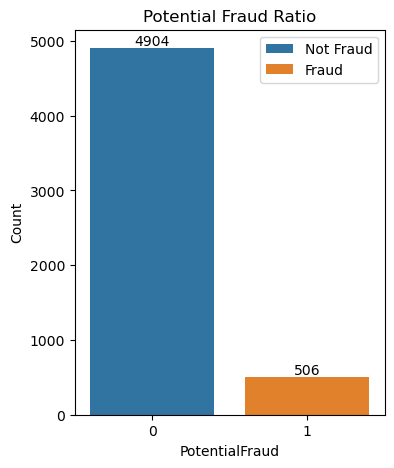

In [24]:
# plot the difference between the fraud and non-fraud providers
fraud_counts = final_df['PotentialFraud'].value_counts()
fraud_data = pd.DataFrame({'PotentialFraud': fraud_counts.index, 'Count': fraud_counts.values})

colors = ['Not Fraud', 'Fraud']
# Create the bar plot
plt.figure(figsize=(4, 5))
ax = sns.barplot(data=fraud_data, x='PotentialFraud', y='Count', hue=colors)

# Add labels to bars
for container in ax.containers:
    ax.bar_label(container, fontsize=10)

plt.title('Potential Fraud Ratio')
plt.show()

In [25]:
final_df.describe()

,IPClaimDurationSum,IPClaimDurationCount,IPClaimDurationMean,OPClaimDurationSum,OPClaimDurationCount,OPClaimDurationMean,PotentialFraud
count,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000
mean,42.346211,7.481331,2.188905,135.944917,95.700000,1.270983,0.093530
std,136.132241,23.704217,3.246215,380.354256,266.520526,1.394756,0.291201
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,7.000000,0.108859,0.000000
50%,0.000000,0.000000,0.000000,36.000000,27.000000,1.179207,0.000000
75%,27.000000,5.000000,4.666667,115.000000,77.000000,1.723329,0.000000
max,3044.000000,516.000000,35.000000,11542.000000,8240.000000,20.000000,1.000000


In [27]:
final_df.isna().sum()

Provider                0
IPClaimDurationSum      0
IPClaimDurationCount    0
IPClaimDurationMean     0
OPClaimDurationSum      0
OPClaimDurationCount    0
OPClaimDurationMean     0
PotentialFraud          0
dtype: int64

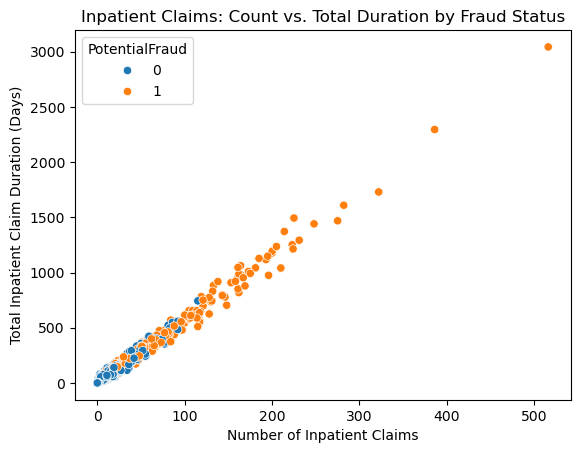

In [28]:
sns.scatterplot(
    x='IPClaimDurationCount', 
    y='IPClaimDurationSum',
    data=final_df,
    hue='PotentialFraud'
    )
plt.title('Inpatient Claims: Count vs. Total Duration by Fraud Status')
plt.xlabel('Number of Inpatient Claims')
plt.ylabel('Total Inpatient Claim Duration (Days)')
plt.show()

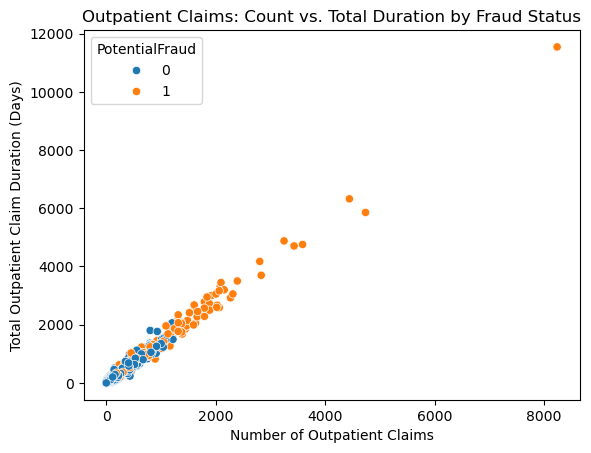

In [29]:
sns.scatterplot(
    x='OPClaimDurationCount', 
    y='OPClaimDurationSum',
    data=final_df,
    hue='PotentialFraud'
    )
plt.title('Outpatient Claims: Count vs. Total Duration by Fraud Status')
plt.xlabel('Number of Outpatient Claims')
plt.ylabel('Total Outpatient Claim Duration (Days)')
plt.show()

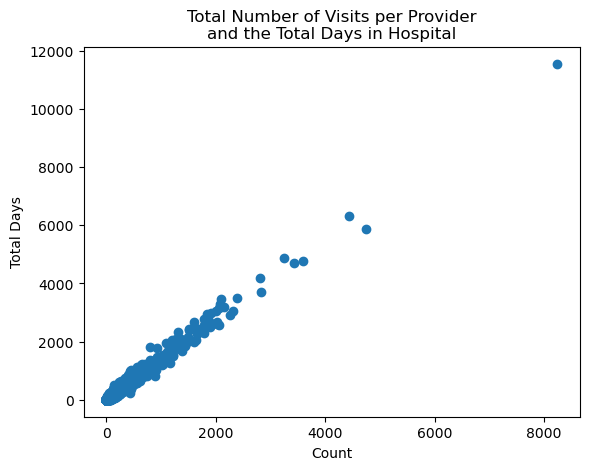

In [30]:
plt.scatter(x=final_df['OPClaimDurationCount'], y=final_df['OPClaimDurationSum'])
plt.title('Total Number of Visits per Provider\nand the Total Days in Hospital')
plt.xlabel('Count')
plt.ylabel('Total Days')
plt.show()

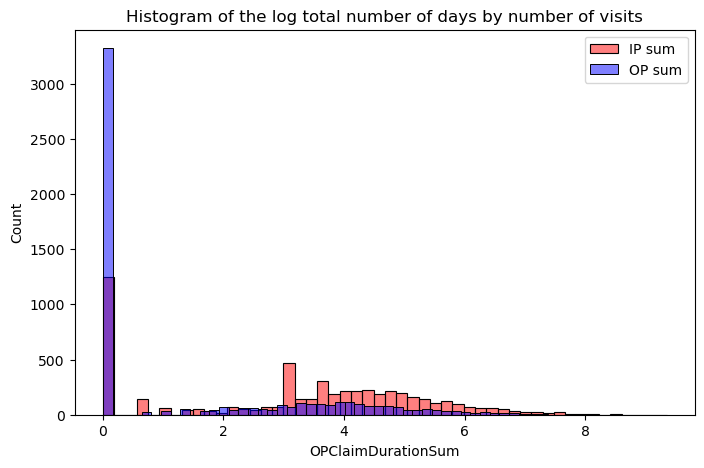

In [32]:
plt.figure(figsize=(8,5))
sns.histplot(np.log1p(final_df['OPClaimDurationSum']), bins=50, color='red', alpha=0.5)
sns.histplot(np.log1p(final_df['IPClaimDurationSum']), bins=50, color='blue', alpha=0.5)
plt.title('Histogram of the log total number of days by number of visits')
plt.legend(['IP sum', 'OP sum'])
plt.show()

In [33]:
final_df['IPClaimDurationSum'].describe()

count    5410.000000
mean       42.346211
std       136.132241
min         0.000000
25%         0.000000
50%         0.000000
75%        27.000000
max      3044.000000
Name: IPClaimDurationSum, dtype: float64

In [518]:
# final_df.des

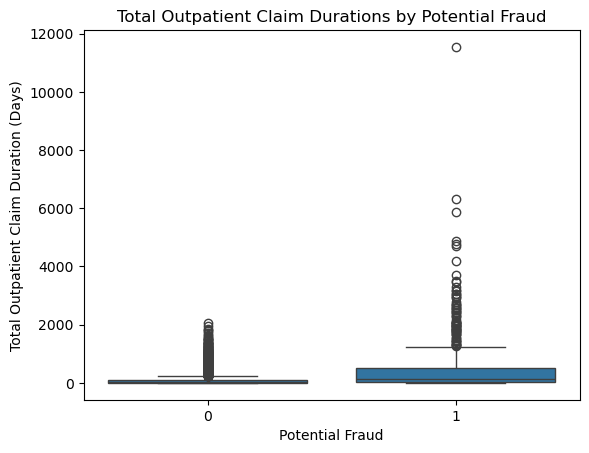

In [42]:
sns.boxplot(
    data=final_df,
    x='PotentialFraud',
    y='OPClaimDurationSum'
)
plt.title('Total Outpatient Claim Durations by Potential Fraud')
plt.xlabel('Potential Fraud')
plt.ylabel('Total Outpatient Claim Duration (Days)')
plt.show()


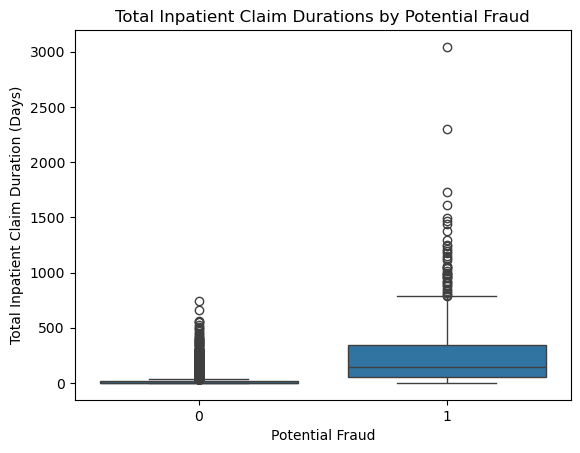

In [43]:
sns.boxplot(
    data=final_df,
    x='PotentialFraud',
    y='IPClaimDurationSum'
)
plt.title('Total Inpatient Claim Durations by Potential Fraud')
plt.xlabel('Potential Fraud')
plt.ylabel('Total Inpatient Claim Duration (Days)')
plt.show()


In [39]:
print(final_df['PotentialFraud'].unique())

[0 1]


/var/folders/dq/lfhw90y53plczdyg_s9ch5q40000gn/T/ipykernel_73108/1899598494.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([OP_no, OP_yes], labels=['No', 'Yes'])
/var/folders/dq/lfhw90y53plczdyg_s9ch5q40000gn/T/ipykernel_73108/1899598494.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([IP_no, IP_yes], labels=['No', 'Yes'])


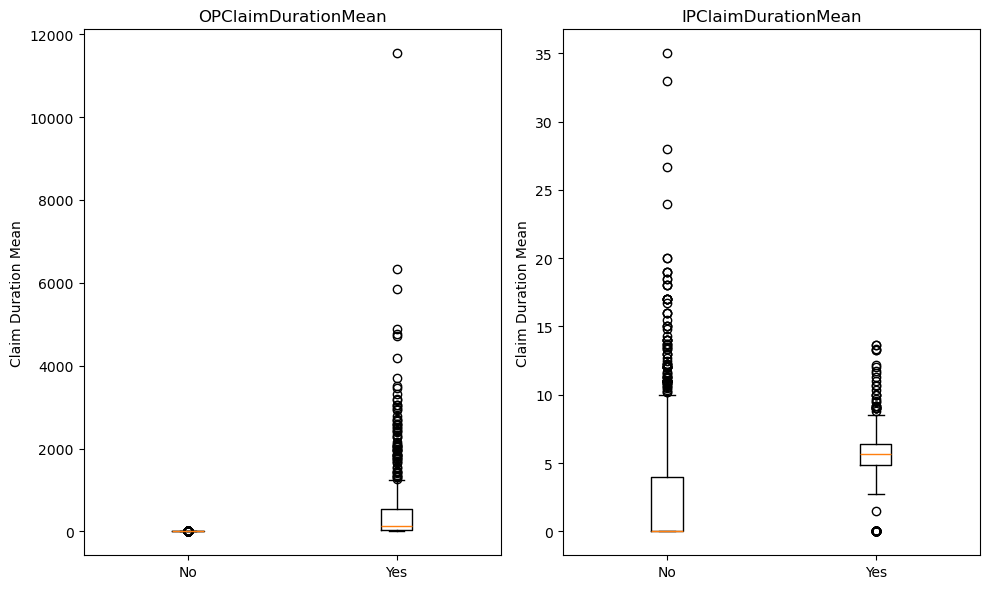

In [521]:
# Filter your data into four separate Series or arrays:
OP_yes = final_df.loc[final_df['PotentialFraud'] == 1, 'OPClaimDurationSum']
OP_no  = final_df.loc[final_df['PotentialFraud'] == 0,  'OPClaimDurationMean']
IP_yes = final_df.loc[final_df['PotentialFraud'] == 1, 'IPClaimDurationMean']
IP_no  = final_df.loc[final_df['PotentialFraud'] == 0,  'IPClaimDurationMean']

# # Create a single figure and axes
# fig, ax = plt.subplots(figsize=(8, 6))

# # Boxplot: pass a list of data in the order you want them displayed
# ax.boxplot(x=[OP_no, OP_yes, IP_no, IP_yes], 
#            tick_labels=['OP_No', 'OP_Yes', 'IP_No', 'IP_Yes'])

# # Labeling
# ax.set_ylabel('Claim Duration Mean')
# ax.set_title('Boxplots by PotentialFraud (OP & IP ClaimDurationMean)')

# plt.tight_layout()
# plt.show()
fig, axes = plt.subplots(ncols=2, figsize=(10, 6))

# Boxplot 1: OPClaimDurationMean
axes[0].boxplot([OP_no, OP_yes], labels=['No', 'Yes'])
axes[0].set_title('OPClaimDurationMean')

# Boxplot 2: IPClaimDurationMean
axes[1].boxplot([IP_no, IP_yes], labels=['No', 'Yes'])
axes[1].set_title('IPClaimDurationMean')

for ax in axes:
    ax.set_ylabel('Claim Duration Mean')

plt.tight_layout()
plt.show()

In [561]:
final_df[['IPClaimDurationSum','OPClaimDurationSum']].describe()

,IPClaimDurationSum,OPClaimDurationSum
count,5410.000000,5410.000000
mean,42.346211,135.944917
std,136.132241,380.354256
min,0.000000,0.000000
25%,0.000000,1.000000
50%,0.000000,36.000000
75%,27.000000,115.000000
max,3044.000000,11542.000000


In [522]:
OP_no

0       0.550000
2       1.429530
4       0.768116
5       1.414634
6       0.473684
          ...   
5405    2.142857
5406    0.318182
5407    1.390244
5408    0.000000
5409    1.720339
Name: OPClaimDurationMean, Length: 4904, dtype: float64

In [523]:
final_df[['OPClaimDurationSum', 
          'OPClaimDurationCount',
          'IPClaimDurationSum', 
          'IPClaimDurationCount']].corr()


,OPClaimDurationSum,OPClaimDurationCount,IPClaimDurationSum,IPClaimDurationCount
OPClaimDurationSum,1.000000,0.989778,0.214121,0.213744
OPClaimDurationCount,0.989778,1.000000,0.208885,0.208758
IPClaimDurationSum,0.214121,0.208885,1.000000,0.993818
IPClaimDurationCount,0.213744,0.208758,0.993818,1.000000


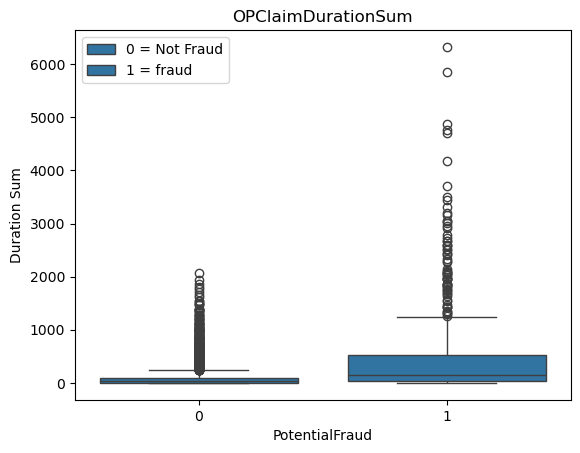

In [576]:
# Identify the row with the max value
max_idx = final_df['OPClaimDurationSum'].idxmax()

# Drop it
extra_df = final_df.drop(index=max_idx)
# extra_df
palette = ['#2196f3', '#ff9800']
sns.boxplot(data=extra_df, x='PotentialFraud', y='OPClaimDurationSum')
plt.title('OPClaimDurationSum')
# plt.xticks(['No', 'Yes'])
plt.ylabel('Duration Sum')
plt.legend(['0 = Not Fraud', '1 = fraud'])
plt.show()

In [574]:
# sns.violinplot(data=final_df, x='PotentialFraud', y='OPClaimDurationSum')
# plt.title('Duration of Treatment')
# plt.legend(['0 = Not Fraud', '1 = fraud'])
# plt.show()

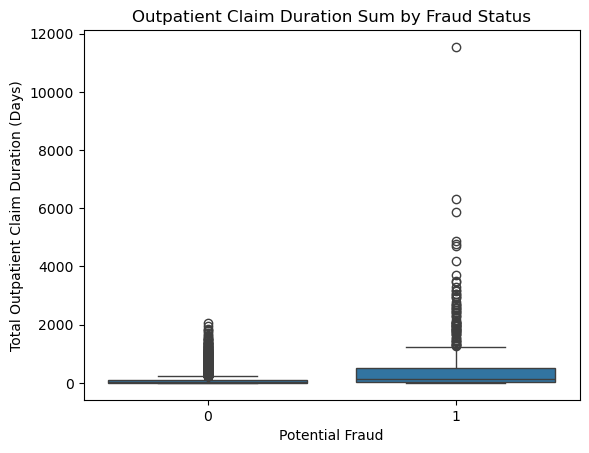

In [526]:
sns.boxplot(
    data=final_df,
    x='PotentialFraud',
    y='OPClaimDurationSum',
    
)
plt.title('Outpatient Claim Duration Sum by Fraud Status')
plt.xlabel('Potential Fraud')
plt.ylabel('Total Outpatient Claim Duration (Days)')
plt.show()


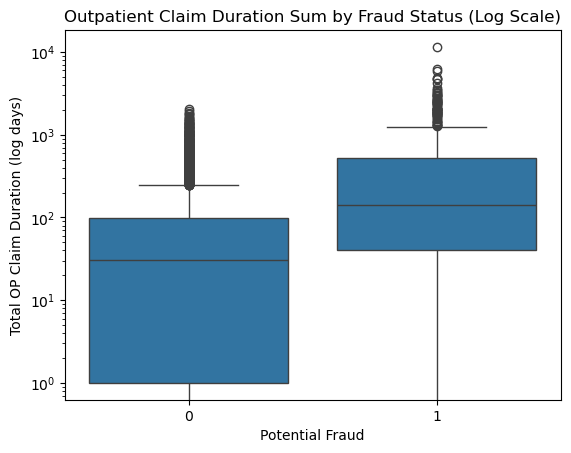

In [527]:
sns.boxplot(
    data=final_df,
    x='PotentialFraud',
    y='OPClaimDurationSum'
)
plt.yscale('log')  # Add log scale for better visibility
plt.title('Outpatient Claim Duration Sum by Fraud Status (Log Scale)')
plt.xlabel('Potential Fraud')
plt.ylabel('Total OP Claim Duration (log days)')
plt.show()

In [528]:

# Create a log-transformed version of the column
extra_df = final_df
extra_df['Log_OPClaimDurationSum'] = np.log1p(extra_df['OPClaimDurationSum'])  # log1p handles 0s safely



Text(0.5, 1.0, 'Boxplot of log-transformed OPClaimDurationSum')

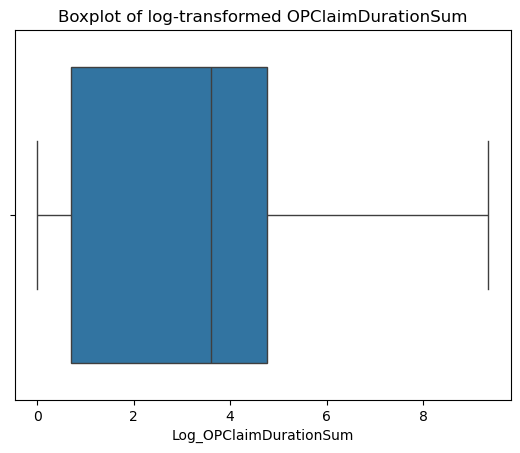

In [529]:
sns.boxplot(x=extra_df['Log_OPClaimDurationSum'])
plt.title("Boxplot of log-transformed OPClaimDurationSum")


In [530]:
# Select the features
X = final_df[['IPClaimDurationSum',
              'IPClaimDurationCount',
              'OPClaimDurationSum',
              'OPClaimDurationCount']]

In [531]:
# Select the target
y = final_df['PotentialFraud']

In [532]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


In [533]:
# 2. Scale the features (standardization: mean = 0, std = 1).
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit on train, then transform
X_test = scaler.transform(X_test)  # Transform test data using train's mean & std


In [534]:
# 3. Train a logistic regression model.
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)  # Fit model on training data

LogisticRegression(random_state=42)

In [535]:
# 4. Make predictions on the test set.
y_predict = model.predict(X_test)  # Outputs predicted class labels (0 or 1)

y_proba = model.predict_proba(X_test)[:, 1] # predict probabilities between the 0 and 1 (good for the threshold later)


In [536]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_predict)
print("Confusion Matrix before manipulating by adjusting the threshold\nConfusion Matrix:")
print(cm)

Confusion Matrix before manipulating by adjusting the threshold
Confusion Matrix:
[[964  13]
 [ 65  40]]


In [537]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
# print('Confusion Matrix before manipulating by adding the threshold:\n')

# Calculating metrics
accuracy = accuracy_score(y_test, y_predict) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.93
Precision: 0.75
Recall: 0.38
F1 Score: 0.51


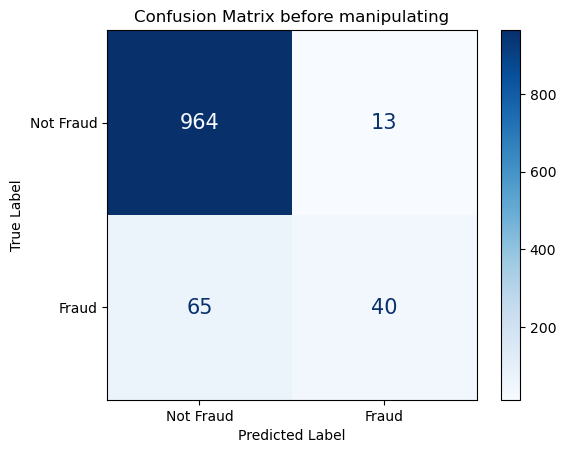

In [538]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Compute and display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues, text_kw={'fontsize': 15})
plt.title('Confusion Matrix before manipulating')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

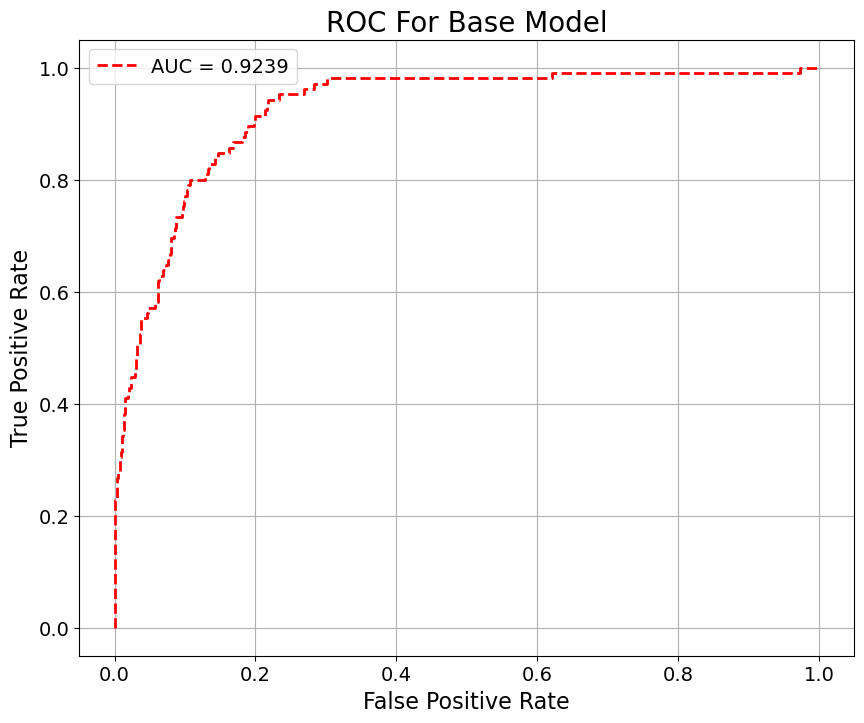

In [539]:
from sklearn.metrics import roc_curve


# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
# roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=f'AUC = {roc_auc:.4f}') #(AUC = {roc_auc:.2f})')
# Add styling with larger fonts
ax.set_title('ROC For Base Model', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14)
ax.grid(True)

In [540]:
from sklearn.metrics import auc
# Area Under Curve
auc(fpr, tpr)

np.float64(0.9239362479894722)

# Apply cross validation

In [541]:
from sklearn.model_selection import cross_val_score

# Define Logistic Regression model
model = LogisticRegression(max_iter=10000)  # Increase max_iter for convergence

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')

# Print cross-validation results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean auc_roc: {cv_scores.mean():.4f}")


Cross-validation scores: [0.94274886 0.94692222 0.91942451 0.93674872 0.93632453]
Mean auc_roc: 0.9364


## Hyperparameter Tuning Using `GridSearchCV`

Checking for the best paramters that will gives the best result in the scoring parameter

In [542]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga']  # Solvers that support L1 & L2
}

# Define logistic regression model
logreg = LogisticRegression(max_iter=10000)

# Perform GridSearchCV optimizing for roc_auc
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Display best parameters and roc_auc score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best roc_auc Score: {grid_search.best_score_:.4f}")


Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best roc_auc Score: 0.9390


In [543]:
from sklearn.metrics import classification_report

# Get the best trained model
best_model = grid_search.best_estimator_

# Predict on test set
y_pred = best_model.predict(X_test)

# Evaluate performance
report = classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud'])
print(report)


              precision    recall  f1-score   support

   Not Fraud       0.93      0.99      0.96       977
       Fraud       0.81      0.28      0.41       105

    accuracy                           0.92      1082
   macro avg       0.87      0.63      0.69      1082
weighted avg       0.92      0.92      0.91      1082



In [544]:
cm = confusion_matrix(y_test, y_pred)

print("confusion Matrix after GridSearch only:\n",cm)

confusion Matrix after GridSearch only:
 [[970   7]
 [ 76  29]]


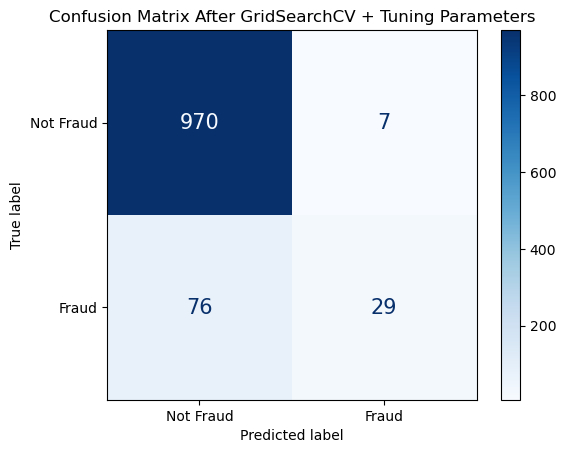

In [545]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap='Blues', text_kw={'fontsize': 15})
plt.title("Confusion Matrix After GridSearchCV + Tuning Parameters")
plt.show()

# <center>SMOTE

In [546]:
# Checks how the data looks like, before applying a new concept (SMOTE)
final_df.head()

,Provider,IPClaimDurationSum,IPClaimDurationCount,IPClaimDurationMean,OPClaimDurationSum,OPClaimDurationCount,OPClaimDurationMean,PotentialFraud,Log_OPClaimDurationSum
0,PRV51001,25.0,5.0,5.000000,11.0,20.0,0.550000,0,2.484907
1,PRV51003,320.0,62.0,5.161290,165.0,70.0,2.357143,1,5.111988
2,PRV51004,0.0,0.0,0.000000,213.0,149.0,1.429530,0,5.365976
3,PRV51005,0.0,0.0,0.000000,1268.0,1165.0,1.088412,1,7.145984
4,PRV51007,16.0,3.0,5.333333,53.0,69.0,0.768116,0,3.988984


In [547]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = final_df.drop(columns=['Provider','PotentialFraud'])
y = final_df['PotentialFraud']

# Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_resampled.value_counts())


Before SMOTE: PotentialFraud
0    3923
1     405
Name: count, dtype: int64
After SMOTE: PotentialFraud
0    3923
1    3923
Name: count, dtype: int64


/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [548]:
model_after_smote = LogisticRegression(max_iter=10000)
model_after_smote.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=10000)

In [549]:
from sklearn.metrics import classification_report

# Predict on the test set (original imbalanced data)
y_pred = model_after_smote.predict(X_test)
y_proba = model_after_smote.predict_proba(X_test)[:, 1] # predict probabilities, what's closer to 0 or 1.


In [550]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[838 143]
 [  6  95]]


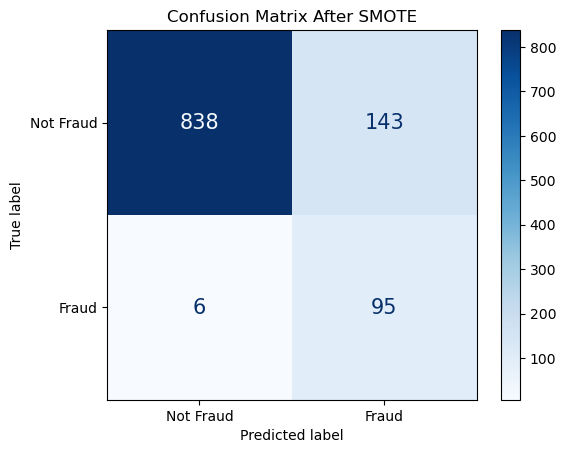

In [551]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap='Blues', text_kw={'fontsize': 15})
plt.title("Confusion Matrix After SMOTE")
plt.show()

In [552]:
# cm = confusion_matrix(y_test, y_pred)
# print('Confusion Matrix smote:\n', cm)

# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
# Calculating metrics
accuracy = accuracy_score(y_test, y_pred) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.86
Precision: 0.40
Recall: 0.94
F1 Score: 0.56


### <center>SMOTE AUC_ROC score:

In [553]:
from sklearn.metrics import roc_auc_score

y_proba = model_after_smote.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (fraud)
auc_score = roc_auc_score(y_test, y_proba)

print(f"ROC-AUC Score: {auc_score:.4f}")


ROC-AUC Score: 0.9564


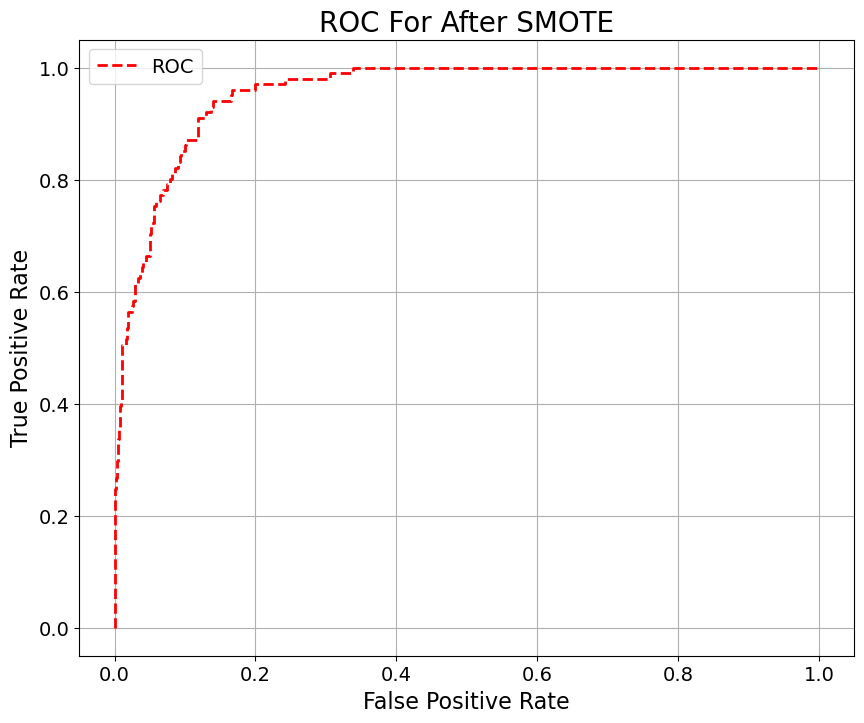

In [554]:
from sklearn.metrics import roc_curve

# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=f'ROC') #(AUC = {roc_auc:.2f})')
# Add styling with larger fonts
ax.set_title('ROC For After SMOTE', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14)
ax.grid(True)

# <center>Grid Search CV
<center>This comes after the smote, so I run the grid search over the smote results

In [555]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2'],  
    'solver': ['liblinear', 'saga']
}

# Use GridSearchCV to optimize for recall
grid_search = GridSearchCV(model_after_smote, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}


In [556]:
from sklearn.metrics import roc_auc_score

y_proba = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (fraud)
auc_score = roc_auc_score(y_test, y_proba)

print(f"ROC-AUC Score for the GridSearchCV over the SMOTE: {auc_score:.4f}")


ROC-AUC Score for the GridSearchCV over the SMOTE: 0.9579


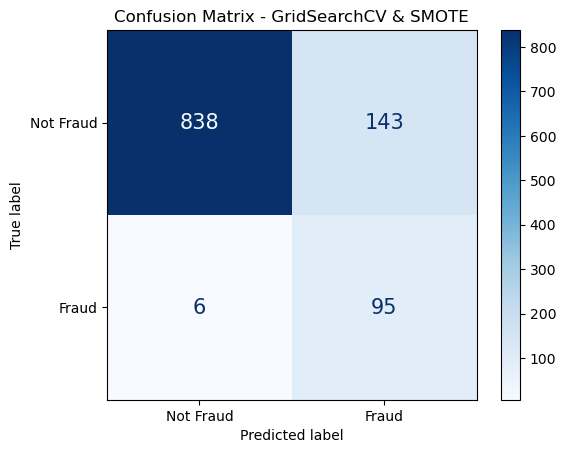

In [557]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap='Blues', text_kw={'fontsize': 15})
plt.title("Confusion Matrix - GridSearchCV & SMOTE")
plt.show()


In [558]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[838 143]
 [  6  95]]


In [559]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
print('Confusion Matrix after all:\n')
# Calculating metrics
accuracy = accuracy_score(y_test, y_pred) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Confusion Matrix after all:

Accuracy: 0.86
Precision: 0.40
Recall: 0.94
F1 Score: 0.56
